In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from Common import *
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Import Data
train_data = pd.read_csv("Task1/TrainingData.txt")
test_data = pd.read_csv("Task1/TestingData.txt")

Tf = torch.from_numpy(train_data['tf0'].to_numpy()).type(torch.float32)
Ts = torch.from_numpy(train_data['ts0'].to_numpy()).type(torch.float32)

t_train = train_data['t'].to_numpy()
t_pred = test_data['t'].to_numpy()
t_pred = np.append(t_pred, t_pred[-1]+(t_pred[1] - t_pred[0]))
t_total = np.append(t_train, t_pred)

In [3]:
#Normalize Data
scaler_t = MinMaxScaler()
scaler_Tf = MinMaxScaler()
scaler_Ts = MinMaxScaler()

n_train = 210
batch_dim = 35
batch_size = 2

t_total_norm = torch.tensor(scaler_t.fit_transform(t_total.reshape(-1,1)), dtype=torch.float)
print(t_total_norm.shape)

Tf_norm = torch.tensor(scaler_Tf.fit_transform(train_data['tf0'].to_numpy().reshape(-1, 1)), dtype=torch.float)
Ts_norm = torch.tensor(scaler_Ts.fit_transform(train_data['ts0'].to_numpy().reshape(-1, 1)), dtype=torch.float )


input_Tf = torch.stack([Tf_norm.reshape(-1), t_total_norm[:-35].reshape(-1)], dim=1).reshape(-1, batch_dim, 2)
input_Ts = torch.stack([Ts_norm.reshape(-1), t_total_norm[:-35].reshape(-1)], dim=1).reshape(-1, batch_dim, 2)

input_Tf_train = input_Tf[:-1, :]
input_Ts_train = input_Ts[:-1, :]

print("Input Ts train shape: {}".format(input_Ts_train.shape))
print("Input Tf train shape: {}".format(input_Tf_train.shape))

output_Tf_train = input_Tf[1:, :, 0]
output_Ts_train = input_Ts[1:, :, 0]

print("Output Ts train shape: {}".format(output_Tf_train.shape))
print("Output Tf train shape: {}".format(output_Ts_train.shape))

torch.Size([245, 1])
Input Ts train shape: torch.Size([5, 35, 2])
Input Tf train shape: torch.Size([5, 35, 2])
Output Ts train shape: torch.Size([5, 35])
Output Tf train shape: torch.Size([5, 35])


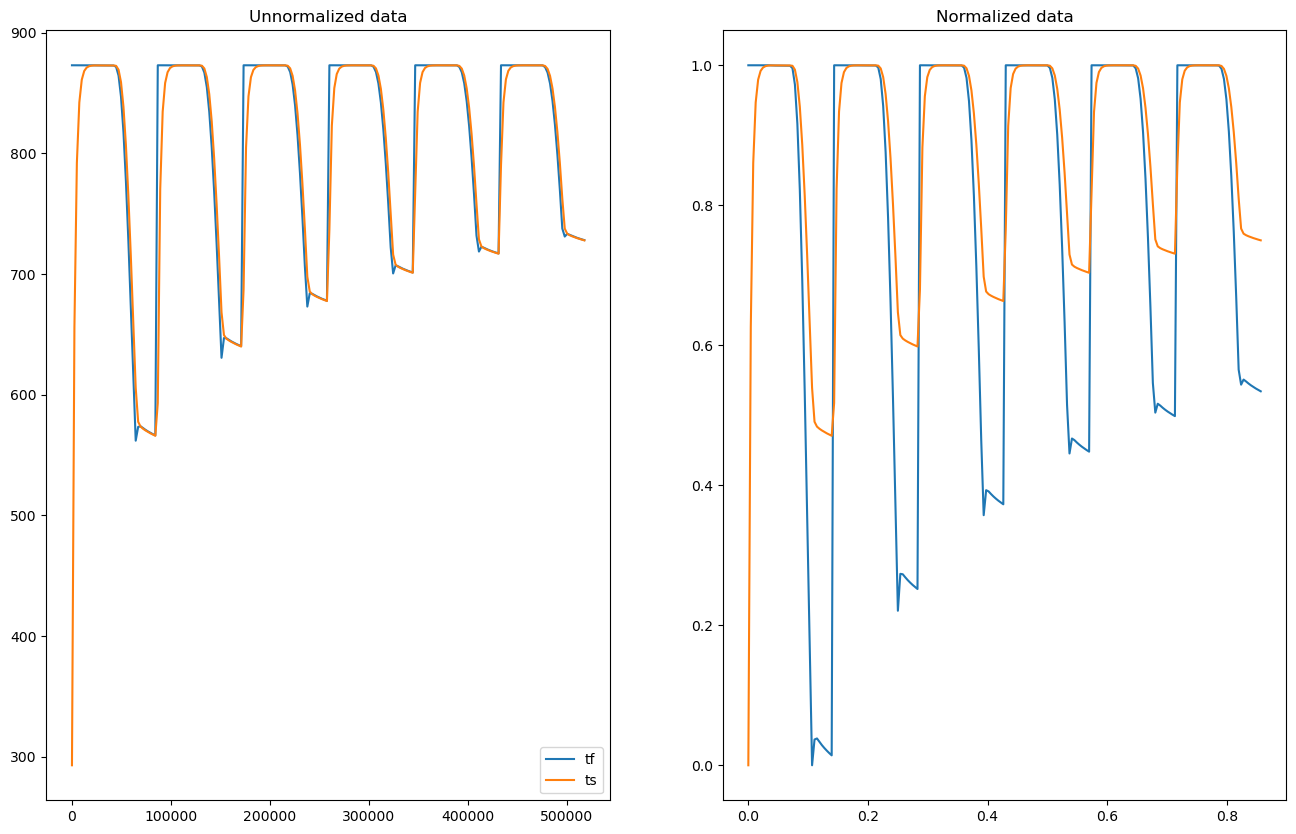

In [4]:
#Plot Unnormalized and Normalized Data
fig, ax = plt.subplots(1,2, figsize = (16, 10))

ax[0].plot(t_total[:-35], Tf, label = "tf")
ax[0].plot(t_total[:-35], Ts, label = 'ts')
ax[0].legend()
ax[0].set_title("Unnormalized data")

ax[1].plot(t_total_norm[:-35], Tf_norm, label = 'tf_norm')
ax[1].plot(t_total_norm[:-35], Ts_norm, label = 'ts_norm')
ax[1].set_title("Normalized data")

plt.show()

In [5]:
training_set_Tf = DataLoader(TensorDataset(input_Tf_train, output_Tf_train), batch_size=batch_size, shuffle=True)
training_set_Ts = DataLoader(TensorDataset(input_Ts_train, output_Ts_train), batch_size=batch_size, shuffle=True)

In [6]:
torch.manual_seed(0)
np.random.seed(0)

learning_rate = 0.001
epochs = 1000
step_size = 50
gamma = 0.5



In [7]:
modes = 16
width = 64

fno_Tf = FNO1d(modes, width) # model
fno_Ts = FNO1d(modes, width) # model


In [9]:
# Training Tf
optimizer = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        optimizer.zero_grad()
        output_pred_batch = fno_Tf(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Tf)

    scheduler.step()

    """
    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)
    """

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:")#, test_relative_l2)



######### Epoch: 0  ######### Train Loss: 0.10503723596533139
######### Epoch: 10  ######### Train Loss: 0.0060712420381605625
######### Epoch: 20  ######### Train Loss: 0.0005682214687112719
######### Epoch: 30  ######### Train Loss: 0.0002365657661963875
######### Epoch: 40  ######### Train Loss: 0.00018707423441810533
######### Epoch: 50  ######### Train Loss: 0.00020079794921912253
######### Epoch: 60  ######### Train Loss: 9.714519546832889e-05
######### Epoch: 70  ######### Train Loss: 0.00013094275891489815
######### Epoch: 80  ######### Train Loss: 9.715720928700951e-05
######### Epoch: 90  ######### Train Loss: 6.18776345315079e-05
######### Epoch: 100  ######### Train Loss: 5.4664555136696436e-05
######### Epoch: 110  ######### Train Loss: 3.872919599719656e-05
######### Epoch: 120  ######### Train Loss: 3.221117064337401e-05
######### Epoch: 130  ######### Train Loss: 3.2749496616209704e-05
######### Epoch: 140  ######### Train Loss: 2.776903329504421e-05
######### Epoch: 15

In [10]:
# Training Ts
optimizer = Adam(fno_Ts.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Ts):
        optimizer.zero_grad()
        output_pred_batch = fno_Ts(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Ts)

    scheduler.step()

    """
    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)
    """

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:")#, test_relative_l2)



######### Epoch: 0  ######### Train Loss: 0.7565148671468099  ######### Relative L2 Test Norm:
######### Epoch: 10  ######### Train Loss: 0.008973735695083937  ######### Relative L2 Test Norm:
######### Epoch: 20  ######### Train Loss: 0.0005238521941161404  ######### Relative L2 Test Norm:
######### Epoch: 30  ######### Train Loss: 0.00013894259366982928  ######### Relative L2 Test Norm:
######### Epoch: 40  ######### Train Loss: 0.00010350384764024056  ######### Relative L2 Test Norm:
######### Epoch: 50  ######### Train Loss: 9.61152181844227e-05  ######### Relative L2 Test Norm:
######### Epoch: 60  ######### Train Loss: 6.313653708881854e-05  ######### Relative L2 Test Norm:
######### Epoch: 70  ######### Train Loss: 6.241677571476127e-05  ######### Relative L2 Test Norm:
######### Epoch: 80  ######### Train Loss: 6.873962289925355e-05  ######### Relative L2 Test Norm:
######### Epoch: 90  ######### Train Loss: 4.5128784525635034e-05  ######### Relative L2 Test Norm:
######### Epo

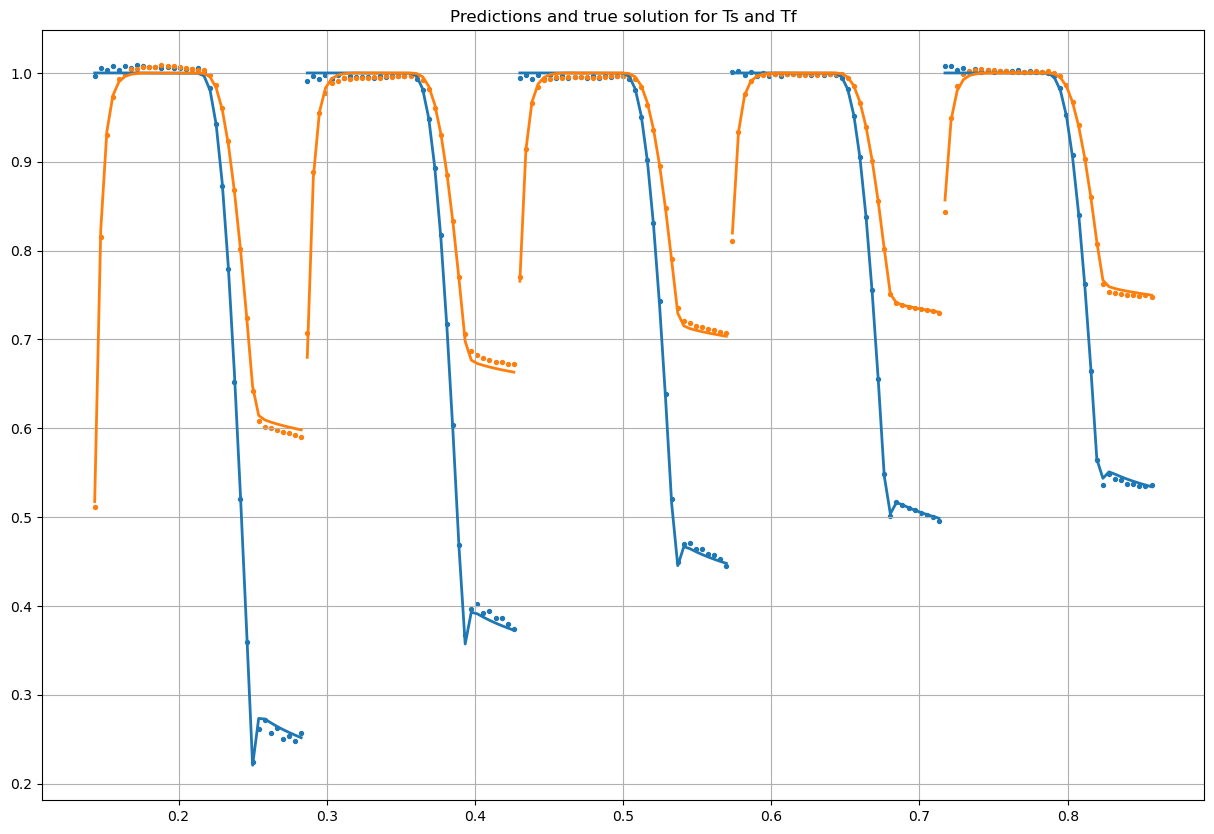

In [11]:
#Plot
fig, ax = plt.subplots(1,1, figsize = (15,10))
ax.grid()
ax.set_title("Predictions and true solution for Ts and Tf")

# fig.figure(dpi=250)
# fig.grid(True, which="both", ls=":")

# Plot fno_Tf & fno_Ts
assert input_Tf.shape[0] == input_Ts.shape[0]

for i in range(input_Tf_train.shape[0]):

    input_function_test_Tf = input_Tf_train[i, :].unsqueeze(0)
    output_function_test_Tf = output_Tf_train[i, :].unsqueeze(0)

    input_function_test_Ts = input_Ts_train[i, :].unsqueeze(0)
    output_function_test_Ts = output_Ts_train[i, :].unsqueeze(0)

    output_function_test_pred_Tf = fno_Tf(input_function_test_Tf)
    output_function_test_pred_Ts = fno_Ts(input_function_test_Ts)
    
    ax.plot(input_Tf[i+1, :][:, 1].detach(), output_function_test_Tf[0].detach(), label="True Solution", c="C0", lw=2)
    ax.scatter(input_Tf[i+1, :][:, 1].detach(), output_function_test_pred_Tf[0].detach(), label="Approximate Solution", s=8, c="C0")

    ax.plot(input_Ts[i+1, :][:, 1].detach(), output_function_test_Ts[0].detach(), label="True Solution", c="C1", lw=2)
    ax.scatter(input_Ts[i+1, :][:, 1].detach(), output_function_test_pred_Ts[0].detach(), label="Approximate Solution", s=8, c="C1")
    # print()
# ax.legend()
plt.show()

torch.Size([175])


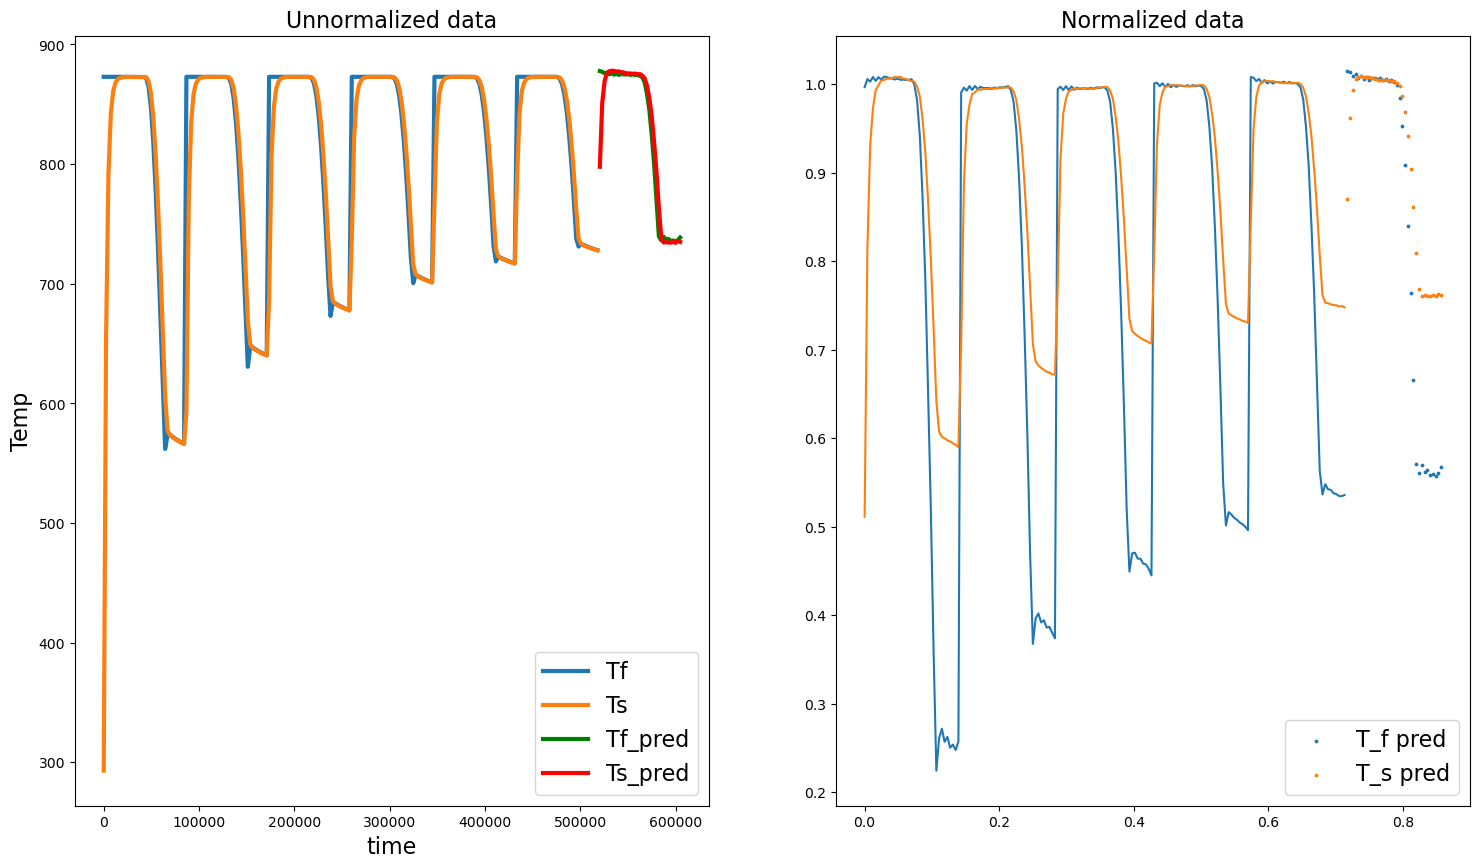

In [13]:
#Get the predictions for the test data (from 0.83 - 1.0)
fontsize = 16
markersize = 3

input_Tf_pred = input_Tf[-1, :].unsqueeze(0)
input_Ts_pred = input_Ts[-1, :].unsqueeze(0)

'''
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Get predictions of test set on normalized input data
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
'''
output_pred_Tf = fno_Tf(input_Tf_pred).squeeze()
output_pred_Ts = fno_Ts(input_Ts_pred).squeeze()
'''
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Invert data to get unnormalized results
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
'''
# Prediction on the test data in the original scale
output_pred_Tf_org = scaler_Tf.inverse_transform(output_pred_Tf.detach().reshape(-1, 1))
output_pred_Ts_org = scaler_Ts.inverse_transform(output_pred_Ts.detach().reshape(-1, 1))


output_pred_Tf_train = fno_Tf(input_Tf_train)
output_pred_Ts_train = fno_Ts(input_Ts_train)

fig, ax = plt.subplots(1,2, figsize = (18,10))

ax[0].plot(t_total[:-35], Tf, label='Tf', linewidth=3)
ax[0].plot(t_total[:-35], Ts, label='Ts', linewidth=3)

ax[0].plot(t_total[-35:], output_pred_Tf_org, label='Tf_pred', c="green", linewidth=3)
ax[0].plot(t_total[-35:], output_pred_Ts_org, label='Ts_pred', c="red", linewidth=3)

ax[0].set_xlabel('time', size=fontsize)
ax[0].set_ylabel('Temp', size=fontsize)
ax[0].legend(fontsize=fontsize)
ax[0].set_title('Unnormalized data', size=fontsize)


ax[1].set_title("Normalized data", size = fontsize)

# print(input_Tf_train[0,:,1].shape)
print(output_pred_Tf_train.view(len(t_train[:-35])).shape)
ax[1].plot(input_Tf_train.reshape(-1,2)[:,1], output_pred_Tf_train.view(len(t_train[:-35])).detach())
ax[1].plot(input_Tf_train.reshape(-1,2)[:,1], output_pred_Ts_train.view(len(t_train[:-35])).detach())

ax[1].scatter(input_Tf_pred[0,:, 1], output_pred_Tf.detach(), label = "T_f pred", s = markersize)
ax[1].scatter(input_Ts_pred[0,:, 1], output_pred_Ts.detach(), label = 'T_s pred', s = markersize)

ax[1].legend(fontsize=fontsize)

plt.show()

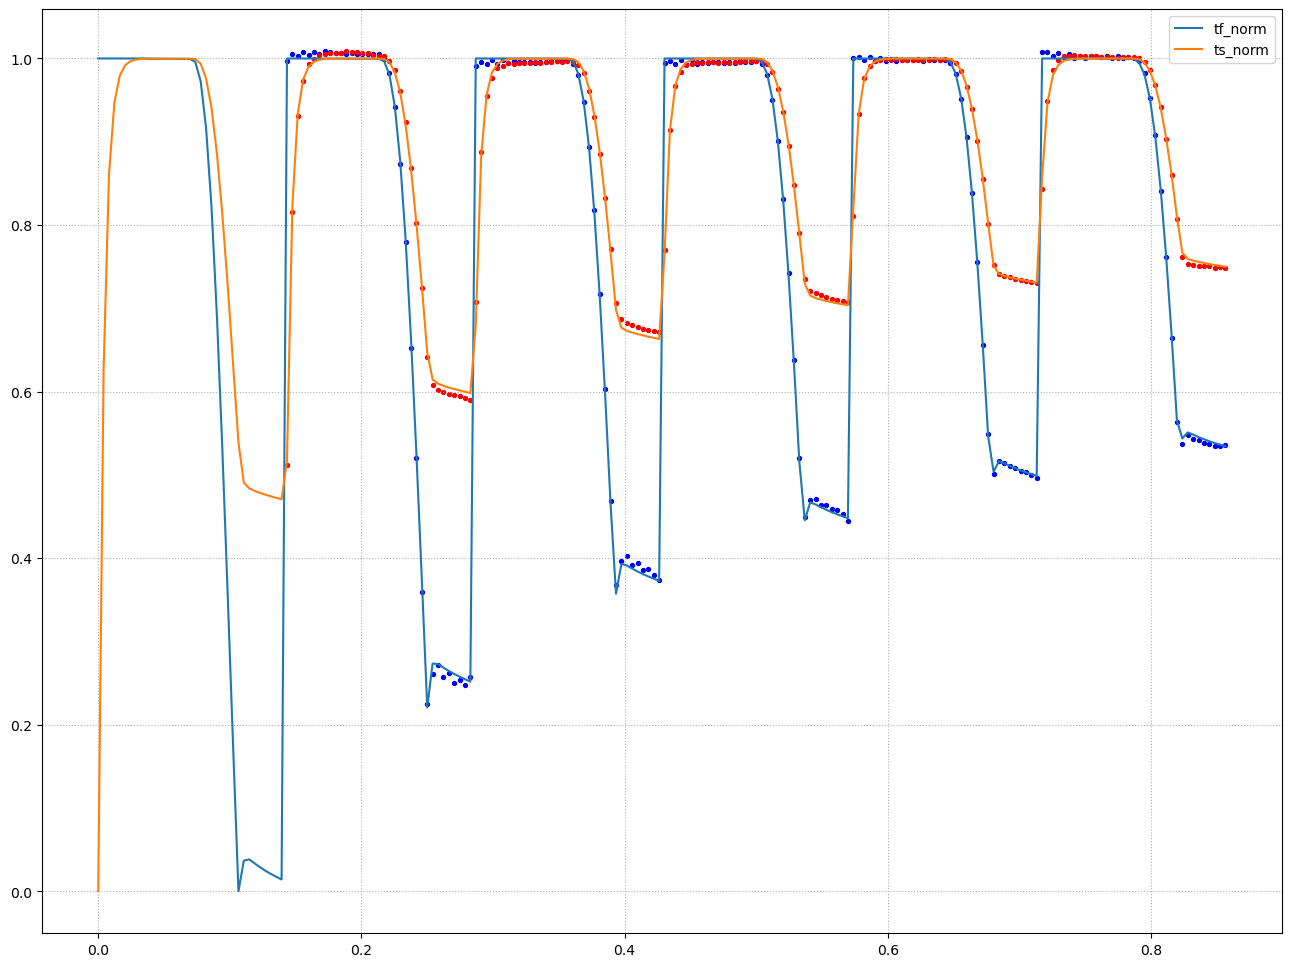

<Figure size 1600x1200 with 0 Axes>

In [14]:
#Compare predictions of training to correct results
fig, ax = plt.subplots(1,1, figsize = (16, 12))
plt.grid(True, which="both", ls=":")
com_div = 35
plt.figure(dpi=250)

batch_size = 35
for i in range(input_Tf_train.shape[0]):
    input_function_n_tf = input_Tf_train[i, :].unsqueeze(0)
    output_pred_tf_n = fno_Tf(input_function_n_tf)
    ax.scatter(input_Tf.reshape(-1,2)[(i+1)*batch_size:(i+1)*batch_size+batch_size, 1].detach(), output_pred_tf_n[0].detach(), s=8, c="blue")

for i in range(input_Ts_train.shape[0]):
    input_function_n_ts = input_Ts_train[i, :].unsqueeze(0)
    output_pred_ts_n = fno_Ts(input_function_n_ts)
    ax.scatter(input_Ts.reshape(-1,2)[(i+1)*batch_size:(i+1)*batch_size+batch_size, 1].detach(), output_pred_ts_n[0].detach(), s=8, c="red")

ax.plot(t_total_norm[:-35], Tf_norm, label = 'tf_norm')
ax.plot(t_total_norm[:-35], Ts_norm, label = 'ts_norm') 
# ax.plot(t_train_norm, Ts0_norm, label = 'ts_norm')
# ax.set_title("Normalized data")
ax.legend()

plt.show()

In [15]:
save_path_pred = "Project_2"

pred_Tf_save = output_pred_Tf_org[:-1].reshape(-1)
pred_Ts_save = output_pred_Ts_org[:-1].reshape(-1)
t_save = t_total[210:-1]
    
try:
    os.makedirs(save_path_pred)
except:
    print("Path already exists")

df_save = pd.DataFrame({'t': t_save, 'tf0': pred_Tf_save, 'ts0': pred_Ts_save})
df_save.to_csv('{}/pred1.txt'.format(save_path_pred), index=False)